In [115]:
from urllib.request import urlopen
import numpy as np
import pandas as pd
import json
import time
import pickle
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from math import sqrt
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
SAVE_PATH='/mnt/data/kiwi_mlweekend_dataset.dump'
%matplotlib inline

### Load Dataset

In [116]:
with open(SAVE_PATH, 'rb') as f:
    data=pickle.load(f)

In [117]:
data=[item for item in data if item[1]]

In [118]:
data_dict=dict()
for feature, fn_val in data:
    if feature in data_dict:
        data_dict[feature].append(fn_val)
    else:
        data_dict[feature]=[fn_val]

In [149]:
def rmse(y_true,y_pred):
    return sqrt(mean_squared_error(y_true,y_pred))

def apply(fn, data_dict):
    res=list()
    for feature in data_dict:
        res.append((feature, fn(data_dict[feature])))
    return res

def plot(x,y,y_pred=None,scatter=True,figsize=(5,5), title=None):
    plt.figure(figsize=figsize)
    if scatter:
        plt.scatter(x, y,  color='black')
    plt.plot(x, y, color='blue', linewidth=2)
    if y_pred is not None:
        plt.plot(x, y_pred, color='red', linewidth=1)
    if title is not None:
        plt.title(title)
    plt.show()

def tupls_to_xy(tupls):
    x,y=zip(*sorted(tupls, key=lambda x: x[0]))
    x=np.array(x).reshape(-1,1)
    y=np.array(y)
    return x,y

def get_model_formula(model):
    feat_names=model.get_params()['polynomialfeatures'].get_feature_names()
    coefs=[np.round(coef) for coef in model.get_params()['ridge'].coef_]
    return [(feat_name.replace('x0','x'), coef) for (feat_name,coef) in list(zip(feat_names,coefs)) if coef!=0]


def formula_to_str(formula_tupls):
    return 'y = '+'+'.join([str(coef)+'*'+feat_name for (feat_name,coef) in reversed(formula_tupls)]).replace('+-','-')

In [120]:
means=apply(np.mean,data_dict)

In [121]:
stds=apply(np.std,data_dict)

In [122]:
x,y_mean=tupls_to_xy(means)

#### Standard deviation

In [123]:
x,y_std=tupls_to_xy(stds)

#### Function to predict

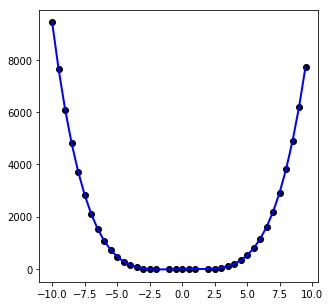

In [124]:
plot(x,y_mean)

#### Standard deviation of random noise also depends on feature

In [151]:
p_val, corr=pearsonr(x.flatten(),y_std)

In [152]:
p_val<0.05

True

In [153]:
corr

0.70880277003918679

### Model training

In [128]:
fn_model = make_pipeline(PolynomialFeatures(10), Ridge())

In [129]:
fn_model.fit(x,y_mean)

Pipeline(memory=None,
     steps=[('polynomialfeatures', PolynomialFeatures(degree=10, include_bias=True, interaction_only=False)), ('ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))])

In [130]:
y_pred_train=fn_model.predict(x)

#### Training error


In [156]:
rmse(y_mean,y_pred_train)

0.2594824959554186

Training data fit

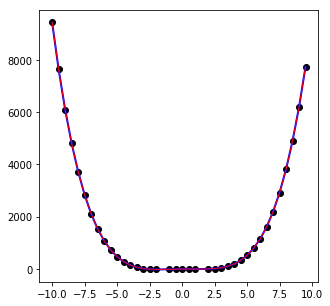

In [157]:
plot(x,y_mean,y_pred=y_pred_train)

### Secret formula

In [158]:
viz_x=np.array(range(-10,11,1)).reshape(-1,1)
viz_y=fn_model.predict(viz_x)

Secret formula is: y = 1.0*x^4-5.0*x^2+5.0*x


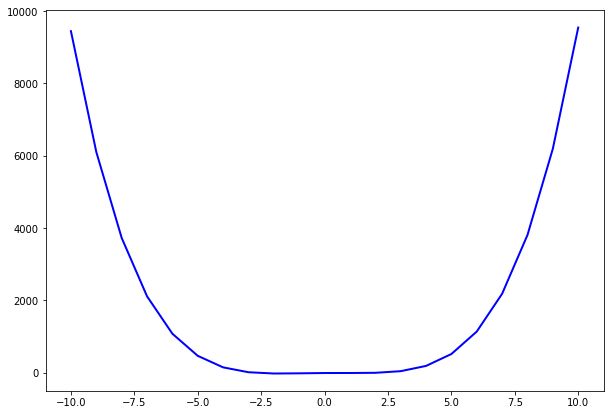

In [161]:
res_str='Secret formula is: '+formula_to_str(get_model_formula(fn_model))
plot(viz_x,viz_y,figsize=(10,7),scatter=False,title=res_str)